# Expectation-maximization algorithm

In this notebook, we will implement the Expectation-Maximization algorithm for a Gaussian Mixture Model, commonly used for perform soft (with probabilities) clustering of data.

**References:**

* For a description of the Expectation-Maximization (EM) algorithm for a Gaussian Mixture Model:

    "Pattern Recognition and Machine Learning" by C. Bishop, 9.2 p. 430


* The algorithm:

    "Pattern Recognition and Machine Learning" by C. Bishop, 9.2.2 p. 438


* For a demonstration of the algorithm and its convergence (to a local maximum of the likelihood):

    "Pattern Recognition and Machine Learning" by C. Bishop, 9.4 p. 450

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import seaborn as sns
import random
sns.set()
plt.style.use('seaborn-whitegrid')
np.random.seed(1)
%matplotlib inline

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

In [2]:
loaded = np.load('data.npz')
X = loaded['X']
pi_test=loaded['pi_test']
mu_test=loaded['mu_test']
sigma_test=loaded['sigma_test']

# We transform into coordinates in the plane to make plotting easier.
x0_range = (X[:,0].min()-1,X[:,0].max()+1)
x1_range = (X[:,1].min()-1,X[:,1].max()+1)
x0 = X[:,0] 
x1 = X[:,1] 

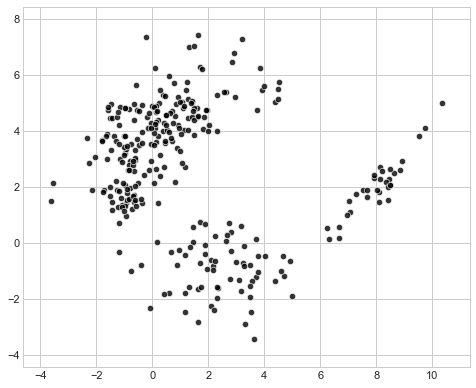

In [45]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, color='Black', s=40,alpha = 0.8,legend='full', ax=ax)
ax.figure.canvas.draw()

## Algorithm

Latent variables $Z$ are indices of components to which each data point is assigned. $Z_n$ (class index for item $n$) is a one-hot encoded vector. For example, if we have $C=3$ classes and object $n$ lies in first class, $Z_n = [1, 0, 0]$.

The joint distribution can be written as follows: 
\begin{align}
 p(Z, X \mid \theta) =  p(X \mid Z,\theta) p(Z \mid \theta) =  \\
 \prod\limits_{n=1}^N p(Z_n, X_n \mid \theta) =
\prod\limits_{i=n}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_n \mid \mu_c, \Sigma_c)]^{Z_{nc}} \;.
\end{align}
where the multivariate normal distribution is given by
$$
\mathcal{N}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^d | \Sigma_c |}} \exp{\left[ 
-\frac{1}{2}
(x-\mu_c)\Sigma_c^{-1}(x-\mu_c)
\right]}
$$



#### Initialization

We first initialize the parameters of the GMM, $\theta$, which consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

#### E-step

Considering the parameters as fixed, we calculate the responsabilities $\gamma_{nc}$. The probability of the point $X_n$ to belong to class $c$. 
$$
\gamma_{nc} \equiv P(Z_{nc} = 1 \mid X_n, \theta)\,,
$$
where $\sum\limits_{c=1}^C\gamma_{nc}=1$.

It is obtained with
$$
\gamma_{nc} = \frac{  \pi_c \mathcal{N}(X_n \mid \mu_c, \Sigma_c)}{ \sum\limits_{c'=1}^C \pi_{c'} \mathcal{N}(X_n \mid \mu_{c'}, \Sigma_{c'})}
$$

#### M-step

We reestimate the parameters considering the responsabilities as fixed. This is really intuitive, because we have to use the Maximum Likelihood Estimate formulae for the mean and covariance matrix of a Gaussian, weightening with the responsabilities:

$$
\mu_{c,i} = \frac{1}{N_c}{\sum_n}\gamma_{nc} x_i^{(n)}
\,,
$$
$$
\Sigma_{c,ij} = \frac{1}{N_c}{\sum_n}\gamma_{nc}  
\left(x^{(n)}-\mu_c \right)_i
\left(x^{(n)}-\mu_c \right)_j
\,,
$$
$$
\pi_c = \frac{N_c}{N}
\,,
$$
where $N_c \equiv \sum_n \gamma_{nc}$

#### Check convergence

Evaluate the log likelihood and check the convergence of either the parameters or the log likelihood.

$$\mathcal{L} = \log{ p( X \mid \theta)  } = 
\sum_n \log{ \left[ \sum_{c=1}^{C} \pi_c \mathcal{N}(X_n \mid \mu_c, \Sigma_c)   \right] } \;.
$$



### E-step

<b>Trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

In [8]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model.

    Parameters
    ----------
    X: np.array, shape=(N x d)
        Features matrix.
    pi: np.array, shape=(C)
        mixture component weights.
    mu: np.array, shape=(C x d) 
        mixture component means.
    sigma: np.array, shape=(C x d x d) 
        mixture component covariance matrices.

    Returns
    -------
    gamma: np.array, shape=(N x C)
        Updated responsabilities.
    """

    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # Initialize responsabilities
                
    ### Calculate the new responsabilities

    return gamma

In [12]:
gamma = E_step(X, pi_test, mu_test, sigma_test)
gamma[:5]

array([[9.99999973e-001, 2.72918622e-008, 2.54046273e-015],
       [7.23827645e-114, 2.97242436e-005, 9.99970276e-001],
       [1.83432416e-090, 1.87362524e-005, 9.99981264e-001],
       [5.48357414e-046, 1.20403164e-002, 9.87959684e-001],
       [3.51738838e-015, 9.99570994e-001, 4.29006416e-004]])

### M-step

In [13]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model.
    
    Parameters
    ----------
    X: np.array, shape=(N x d)
        Features matrix.
    gamma: np.array, shape=(N x C)
        Updated responsabilities.
    
    Returns
    -------
    pi: np.array, shape=(C)
        Updated mixture component weights .
    mu: np.array, shape=(C x d) 
        Updated mixture component means.
    sigma: np.array, shape=(C x d x d) 
        Updated mixture component covariance matrices.
    """

    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    sigma=np.zeros((C,d,d))

    ### Calculate the updated pi,mu and sigma
    
  

    return pi, mu, sigma

In [14]:
gamma = E_step(X, pi_test, mu_test, sigma_test)
pi, mu, sigma = M_step(X, gamma)
print(pi,mu,sigma)

[0.13374028 0.24488296 0.62137676] [[ 8.00165188e+00  2.01489065e+00]
 [ 2.32920883e+00 -8.60284332e-01]
 [ 3.02102743e-03  3.72639546e+00]] [[[ 1.37128092  1.28071844]
  [ 1.28071844  1.43939334]]

 [[ 1.71343887 -0.29662696]
  [-0.29662696  0.95470694]]

 [[ 1.8197367   1.11108009]
  [ 1.11108009  2.20945985]]]


### Loss function

Finally, we need some function to track convergence. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

In [15]:
def compute_loss(X, pi, mu, sigma, gamma):
    """
    Compute loss function on GMM model.
    
    Parameters
    ----------
    X: np.array, shape=(N x d)
        Features matrix.
    pi: np.array, shape=(C)
        Updated mixture component weights .
    mu: np.array, shape=(C x d) 
        Updated mixture component means.
    sigma: np.array, shape=(C x d x d) 
        Updated mixture component covariance matrices.
    gamma: np.array, shape=(N x C)
        Updated responsabilities.
    
    Returns
    -------
    loss : float
        Log likelihood
    """

    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    ### Calculate the log likelihood. 
    # Be careful with the numerical errors.
    


    return loss

In [16]:
pi, mu, sigma = pi_test, mu_test, sigma_test
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_loss(X, pi, mu, sigma, gamma)
loss

-1204.624635882561

### Training loop

Now we have to combine everything into a training loop. 

We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when  a maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

In [17]:
def train_EM(X, C, rtol=0.5e-3, max_iter=50, restarts=15, verbose = False):
    """
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    Parameters
    ----------
    X: np.array, shape=(N x d)
        Features matrix.
    C: int 
        Number of classes.
    rtol: float, default=0.5e-3
        Maximum relative tolerance to stop the training loop.
    max_iter: int, default=50
        Maximum number of iterations in the training loop.
    restarts: int, default=15
        Number of initializations of the parameters.
    verbose: bool, default = False
        If True, print errors and the loss at each restart.
    
    Returns
    -------
    best_loss: float
        Log likelihood of the best fit.
    best_pi: np.array, shape=(C)
        Best fit of mixture component weights 
    best_mu: np.array, shape=(C x d) 
        Best fit of mixture component means
    best_sigma: np.array, shape=(C x d x d) 
        Best fit of mixture component covariance matrices
    """

    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = -10**(100)
    best_pi = None
    best_mu = None
    best_sigma = None
    
    for restart_index in range(restarts):
        try:
            ### Initialize the parameters: pi, mu and sigma

            loss0 = -10**(100)
            
            for i in range(max_iter):
                ### Apply the E and M steps and compute the loss.
            
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_loss(X, pi, mu, sigma, gamma)
                # print("Iteration=",i," Loss=",loss)
                
                ### Check the convergence properties
                if loss < loss0:
                    loss=-10**(100)
                    if verbose: print(restart_index,") CONVERGENCE PROBLEM")
                    break
                if ( np.abs(1.-loss/loss0) <= rtol ):
                    if verbose: print(restart_index,") Loss has converged=",loss)       
                    break
                loss0=loss
                
            # We save the best parameters and loss
            if loss > best_loss:
                best_loss, best_pi, best_mu, best_sigma = loss,pi,mu,sigma
        except np.linalg.LinAlgError:
            if verbose: print(restart_index,") Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

If the algorithm is correct, it should converge in about 20 iterations. In order to compute the probabilities, we use the `E_step` function to compute the responsabilities of the best fit.

In [18]:
n_classes = 3
best_loss, best_pi, best_mu, best_sigma = train_EM(X, n_classes, verbose=True, restarts=5)

0 ) Loss has converged= -1206.444236290243
1 ) Loss has converged= -1204.63076519899
2 ) Loss has converged= -1351.6508543341015
3 ) Loss has converged= -1209.6479797763764
4 ) Loss has converged= -1258.6057036989855


## Testing the algorithm

Number of classes: 3
Best loss: -1192.748894833661


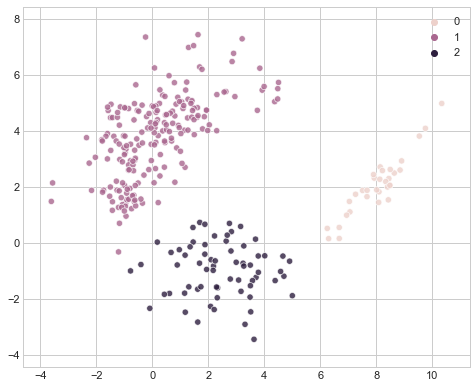

In [42]:
n_classes = 3
best_loss, best_pi, best_mu, best_sigma = train_EM(X, n_classes)

gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
print('Number of classes:', n_classes)
print('Best loss:',best_loss)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, hue=labels, s=40, alpha = 0.8,legend='full', ax=ax)
ax.figure.canvas.draw()

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Number of classes: 4
Best loss: -1161.391907144745


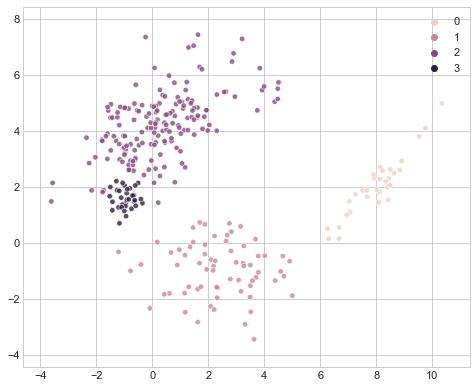

In [40]:
n_classes = 4
best_loss, best_pi, best_mu, best_sigma = train_EM(X, n_classes)

gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
print('Number of classes:', n_classes)
print('Best loss:',best_loss)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, hue=labels, s=40, alpha = 0.8,legend='full', ax=ax)
ax.figure.canvas.draw()

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Number of classes: 5
Best loss: -1154.9723699069218


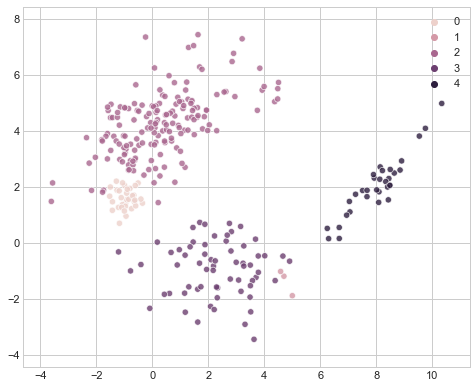

In [43]:
n_classes = 5
best_loss, best_pi, best_mu, best_sigma = train_EM(X, n_classes)

gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
print('Number of classes:', n_classes)
print('Best loss:',best_loss)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, hue=labels, s=40, alpha = 0.8,legend='full', ax=ax)
ax.figure.canvas.draw()

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Number of classes: 6
Best loss: -1150.1507830535309


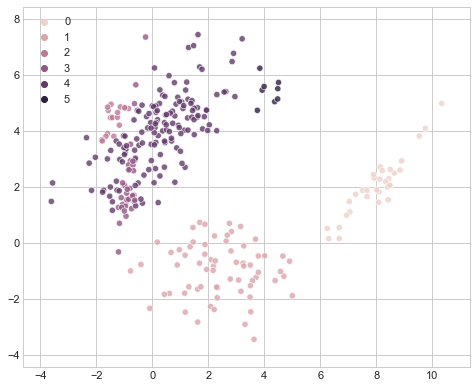

In [44]:
n_classes = 6
best_loss, best_pi, best_mu, best_sigma = train_EM(X, n_classes)

gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
print('Number of classes:', n_classes)
print('Best loss:',best_loss)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, hue=labels, s=40, alpha = 0.8,legend='full', ax=ax)
ax.figure.canvas.draw()

## Ground truth

In [24]:
loaded = np.load('data.npz')
X = loaded['X']
pi_test=loaded['pi_test']
mu_test=loaded['mu_test']
sigma_test=loaded['sigma_test']
Y = np.load('labels.npz')['Y']

# # We transform into coordinates in the plane to make plotting easier.

x0_range = (X[:,0].min()-1,X[:,0].max()+1)
x1_range = (X[:,1].min()-1,X[:,1].max()+1)
x0 = X[:,0] 
x1 = X[:,1] 

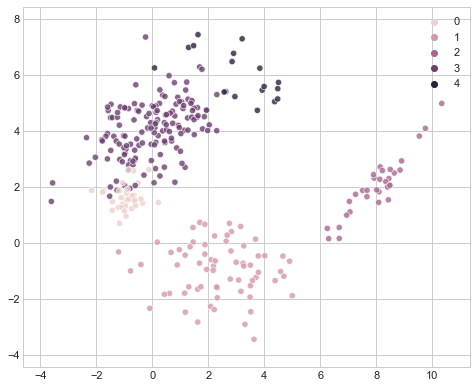

In [46]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
sns.scatterplot(x = x0, y = x1, hue = Y, alpha = 0.8,s=40, legend='full', ax=ax)
ax.figure.canvas.draw()